In [318]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer

In [319]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fredd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fredd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [320]:
df = pd.read_csv('data.tsv', sep='\t')

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [322]:
df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [323]:
df['sentiment_label'].value_counts()

4    80000
0    80000
Name: sentiment_label, dtype: int64

In [324]:
pattern = r'[^a-zA-Z0-9\s]'

In [325]:
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub(pattern, '', x).lower())

In [326]:
lemmatizer = WordNetLemmatizer()

In [327]:
def lemm(text):
    words = word_tokenize(text)
    lemm_words = [lemmatizer.lemmatize(word) for word in words]
    return lemm_words

In [328]:
df['tweet_text'] = df['tweet_text'].apply(lemm)

In [329]:
df['tweet_text'] = df['tweet_text'].apply(lambda x: ' '.join(x))

In [330]:
df['sentiment_label'] = df['sentiment_label'].apply(lambda x: 1 if x == 4 else 0)

In [331]:
X = df['tweet_text']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [332]:
tfidf_vectorizer = TfidfVectorizer()

In [333]:
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [334]:
regressor = LogisticRegression()

In [335]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_prob = regressor.predict_proba(X_test)[:, 1]

In [336]:
print("\n\nAccuracy:", accuracy_score(y_test, y_pred), "\n\nROC:", roc_auc_score(y_test, y_pred), "\n\nClassification report:\n", classification_report(y_test, y_pred))



Accuracy: 0.7844375 

ROC: 0.7844379419443429 

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78     16002
           1       0.78      0.79      0.79     15998

    accuracy                           0.78     32000
   macro avg       0.78      0.78      0.78     32000
weighted avg       0.78      0.78      0.78     32000



In [337]:
import lightgbm as lgb

In [338]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [339]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'num_leaves': 100,
}

In [340]:
model_lgb = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=500, callbacks=[lgb.early_stopping(stopping_rounds=50)])
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

[LightGBM] [Info] Number of positive: 64002, number of negative: 63998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.760072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206785
[LightGBM] [Info] Number of data points in the train set: 128000, number of used features: 4302
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.366214	valid_1's binary_logloss: 0.458111


In [341]:
y_pred_binary = (y_pred >= 0.5).astype(int)

In [342]:
print("\n\nAccuracy:", accuracy_score(y_test, y_pred_binary), "\n\nROC:", roc_auc_score(y_test, y_pred_binary), "\n\nClassification report:\n", classification_report(y_test, y_pred_binary))



Accuracy: 0.78584375 

ROC: 0.7858443208725675 

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78     16002
           1       0.78      0.79      0.79     15998

    accuracy                           0.79     32000
   macro avg       0.79      0.79      0.79     32000
weighted avg       0.79      0.79      0.79     32000



In [343]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

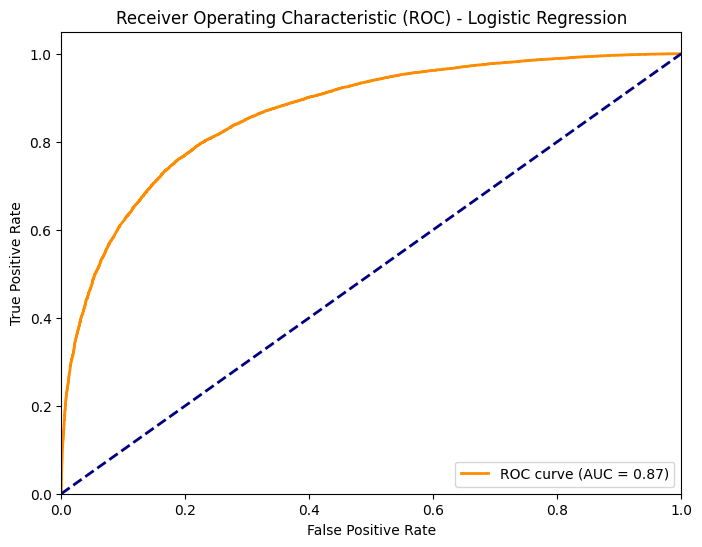

In [344]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('plots\\roc_logisticregression.png', dpi=300)
plt.show()

In [263]:
tokenizer = Tokenizer(num_words=10000)

In [264]:
X = df['tweet_text']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [265]:
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [266]:
max_length = 50

In [268]:
X_train_seq = pad_sequences(X_train_seq, maxlen=max_length)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_length)

In [269]:
X_train_seq = np.array(X_train_seq)
X_test_seq = np.array(X_test_seq)

In [270]:
y_train = np.array(y_train.tolist())
y_test = np.array(y_test.tolist())

In [271]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', restore_best_weights=True)

In [272]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=50, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [273]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [274]:
model.fit(X_train_seq, y_train, epochs=10, batch_size=10, verbose=1, validation_data=(X_test_seq, y_test), callbacks=[early_stopping])

Epoch 1/10
12800/12800 [==============================] - 53s 4ms/step - loss: 0.4952 - accuracy: 0.7633 - val_loss: 0.4696 - val_accuracy: 0.7818
Epoch 2/10
12800/12800 [==============================] - 52s 4ms/step - loss: 0.4195 - accuracy: 0.8124 - val_loss: 0.4877 - val_accuracy: 0.7762
Epoch 3/10
12800/12800 [==============================] - 52s 4ms/step - loss: 0.3453 - accuracy: 0.8533 - val_loss: 0.5384 - val_accuracy: 0.7631
Epoch 4/10
12800/12800 [==============================] - 53s 4ms/step - loss: 0.2840 - accuracy: 0.8825 - val_loss: 0.6102 - val_accuracy: 0.7502
Epoch 5/10
12800/12800 [==============================] - 52s 4ms/step - loss: 0.2430 - accuracy: 0.9014 - val_loss: 0.6842 - val_accuracy: 0.7454
Epoch 6/10
12800/12800 [==============================] - 51s 4ms/step - loss: 0.2154 - accuracy: 0.9129 - val_loss: 0.7595 - val_accuracy: 0.7343
Epoch 7/10
12800/12800 [==============================] - 51s 4ms/step - loss: 0.1947 - accuracy: 0.9212 - val_loss: 0

In [345]:
max_length = 128
max_features = 30522

In [346]:
X = df['tweet_text']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [347]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train_encoded = [tokenizer.encode(text, add_special_tokens=True) for text in X_train]
X_test_encoded = [tokenizer.encode(text, add_special_tokens=True) for text in X_test]

X_train_padded = pad_sequences(X_train_encoded, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_length, padding='post')


In [348]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)


In [349]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_length, mask_zero=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

In [350]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [351]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [352]:
history = model.fit(train_dataset, epochs=10, validation_data=(X_test_padded, y_test), callbacks=[early_stopping])

Epoch 1/10


4000/4000 [==============================] - 317s 78ms/step - loss: 0.4773 - accuracy: 0.7719 - val_loss: 0.4650 - val_accuracy: 0.7774
Epoch 2/10
4000/4000 [==============================] - 310s 78ms/step - loss: 0.3903 - accuracy: 0.8223 - val_loss: 0.4636 - val_accuracy: 0.7866
Epoch 3/10
4000/4000 [==============================] - 310s 77ms/step - loss: 0.3073 - accuracy: 0.8671 - val_loss: 0.5538 - val_accuracy: 0.7753
Epoch 4/10
4000/4000 [==============================] - 309s 77ms/step - loss: 0.2238 - accuracy: 0.9088 - val_loss: 0.6986 - val_accuracy: 0.7456
Epoch 5/10
4000/4000 [==============================] - 310s 78ms/step - loss: 0.1652 - accuracy: 0.9358 - val_loss: 0.8177 - val_accuracy: 0.7536
Epoch 5: early stopping


In [353]:
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=2)

1000/1000 - 15s - loss: 0.4636 - accuracy: 0.7866 - 15s/epoch - 15ms/step


In [354]:
predictions = model.predict(X_test_padded)

1000/1000 [==============================] - 16s 15ms/step


In [360]:
y_pred_binary = (predictions >= 0.5).astype(int)

In [361]:
print("\n\nAccuracy:", accuracy_score(y_test, y_pred_binary), "\n\nROC:", roc_auc_score(y_test, y_pred_binary), "\n\nClassification report:\n", classification_report(y_test, y_pred_binary))



Accuracy: 0.78659375 

ROC: 0.7865955943218061 

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78     16002
           1       0.78      0.80      0.79     15998

    accuracy                           0.79     32000
   macro avg       0.79      0.79      0.79     32000
weighted avg       0.79      0.79      0.79     32000



In [362]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

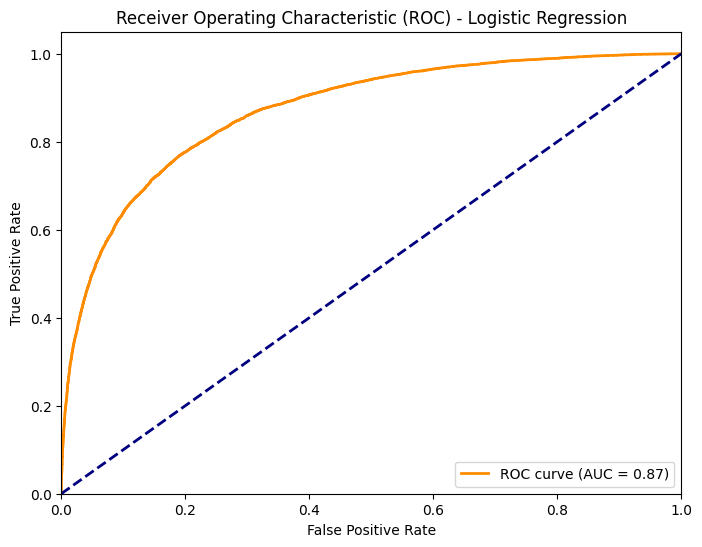

In [363]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('plots\\roc_nn.png', dpi=300)
plt.show()